## TF reporter activity analysis

### Figure 2 - Identify reporter design rules using log-linear models

---
Load libraries

In [1]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import f as f_dist
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
plt.rcParams['pdf.use14corefonts'] = True # Edit text in Adobe Illustrator

/tmp/ipykernel_47286/423552735.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data**

In [2]:
# Import processed bc counts from the preprocessing step
cDNA_df = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv")

# We are not going to use NIH3T3 data, so remove it for now
cDNA_df = cDNA_df[cDNA_df['cell'] != "NIH3T3"]

# Rename stimulation status of control conditions
cDNA_df['stimulation'].fillna("no", inplace=True)

# Import referece conditions
ref_conditions = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/ref_conditions.tsv", sep='\t')

# Load RNA data
tf_rna = pd.read_csv("/DATA/usr/m.trauernicht/data/RNA_seq/rna_tpm_all_tfs.tsv", sep='\t')

---
**Prepare data**

In [3]:
# Only include 2-3 most interesting conditions per TF (as determined before)
ref_conditions_sel = ref_conditions.copy()
ref_conditions_sel['tf_condition'] = ref_conditions_sel['tf'].astype(str) + '_' + ref_conditions_sel['condition'].astype(str)

cDNA_df_TF = cDNA_df.copy()
cDNA_df_TF = cDNA_df_TF[(cDNA_df_TF['neg_ctrls'] == 'No') &
                        (cDNA_df_TF['commercial_reporter'] == 'No') &
                        (cDNA_df_TF['hPGK'] == 'No') &
                        (cDNA_df_TF['native_enhancer'] == 'No') &
                        (cDNA_df_TF['stimulation'].isin(['no', 'pathway', 'overexpression'])) &
                        (cDNA_df_TF['promoter'] != 'Random')]
cDNA_df_TF = cDNA_df_TF[['reporter_activity_minP', 'promoter', 'spacing', 'distance', 'background', 'tf', 'condition', 'reporter_id', 'stimulation']].drop_duplicates()
cDNA_df_TF['tf_condition'] = cDNA_df_TF['tf'].astype(str) + '_' + cDNA_df_TF['condition'].astype(str)
cDNA_df_TF = cDNA_df_TF[cDNA_df_TF['tf_condition'].isin(ref_conditions_sel['tf_condition'])]
cDNA_df_TF['reporter_activity_minP'] = np.log2(cDNA_df_TF['reporter_activity_minP'])
# Round background to integer
cDNA_df_TF['background'] = cDNA_df_TF['background'].astype(int)
cDNA_df_TF['promoter'] = cDNA_df_TF['promoter'].astype('category')
cDNA_df_TF['spacing'] = cDNA_df_TF['spacing'].astype('category')
cDNA_df_TF['spacing_background'] = cDNA_df_TF['spacing'].astype(str) + ':' + cDNA_df_TF['background'].astype(str)
cDNA_df_TF = cDNA_df_TF[['reporter_activity_minP', 'promoter', 'spacing_background', 'distance', 'condition', 'tf', 'tf_condition', 'reporter_id']].drop_duplicates()
## for each tf and condition in cDNA_df_TF, randomly reassign the reporter_activity_minP to reporter_IDs
cDNA_df_TF['reporter_activity_minP_random'] = cDNA_df_TF.groupby(['tf_condition'])['reporter_activity_minP'].transform(lambda x: x.sample(frac=1).values)

# Create dataframes
exp_variance = pd.DataFrame({"feature": ["promoter", "spacing_background", "distance", "Residual"]})
weight = pd.DataFrame({"feature": ["(Intercept)", "promoterminP", "promoterhBGm", "promotermCMV",
                  "spacing_background10bp:1","spacing_background10bp:2","spacing_background10bp:3",
                  "spacing_background5bp:1","spacing_background5bp:2","spacing_background5bp:3",
                  "distance10bp","distance21bp"]})

# Relevel 'promoter' and 'spacing_background' columns
cDNA_df_TF['promoter'] = pd.Categorical(cDNA_df_TF['promoter'], categories=['minP', 'hBGm', 'mCMV'], ordered=True)
cDNA_df_TF['spacing_background'] = pd.Categorical(cDNA_df_TF['spacing_background'], categories=['5bp:1',  '5bp:2', '5bp:3', '10bp:1', '10bp:2', '10bp:3'], ordered=True)

# Add 'row' column
cDNA_df_TF['row'] = cDNA_df_TF.index

# Create an empty dataframe
cDNA_df_TF3 = pd.DataFrame()

---
### Run log-linear models

In [4]:
lm_list = {}
for i in cDNA_df_TF['tf_condition'].unique():
    subset = cDNA_df_TF[cDNA_df_TF['tf_condition'] == i]
    if len(subset) > 9:
        print(i)
        model = smf.ols(formula='reporter_activity_minP ~ distance + promoter + spacing_background', data=subset)
        lm_list[i] = model.fit()


# Get F-statistics
f = {name: lm_list[name].fvalue for name in lm_list}

# Calculate p-values
p = {name: f_dist.sf(f[name], lm_list[name].df_model, lm_list[name].df_resid) for name in f}
p = pd.DataFrame(list(p.items()), columns=['tf_condition', 'pval'])

# Get predicted values
y = []
for name in lm_list:
    df = pd.DataFrame({'activity_predicted': lm_list[name].fittedvalues})
    df['row'] = df.index
    df['tf_condition'] = name
    y.append(df)
y = pd.concat(y).merge(p, on='tf_condition')

# Merge y and cDNA_df_TF
cDNA_df_TF2 = pd.merge(y, cDNA_df_TF, how='left', on='row')

# Concatenate cDNA_df_TF3 and cDNA_df_TF2
cDNA_df_TF3 = pd.concat([cDNA_df_TF3, cDNA_df_TF2])

# Calculate mean of 'pval' column
mean_pval = cDNA_df_TF3['pval'].mean()

# Create a list of dataframes with 'weight' and 'pval' columns
w = []
for name in lm_list:
    if len(lm_list[name].params) == len(lm_list[name].pvalues):
        df = pd.DataFrame({'weight': lm_list[name].params, 'pval': lm_list[name].pvalues})
        df['tf'] = name
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'feature'}, inplace=True)
        w.append(df)

# Concatenate dataframes in w and merge with weight
w = pd.concat(w)
w['feature'] = w['feature'].str.replace('[T.', '')
w['feature'] = w['feature'].str.replace(']', '')
weight = pd.merge(weight, w, how='left', on='feature')

# Create a list of dataframes with ANOVA results
x = [pd.DataFrame(sm.stats.anova_lm(lm_list[name], typ=2)).reset_index().rename(columns={'index': 'feature'}) for name in lm_list]
for df, name in zip(x, lm_list):
    df['tf'] = name

# Concatenate dataframes in x and calculate relative sum of squares
x = pd.concat(x).rename(columns={"Sum Sq": "sum_sq", "PR(>F)": "pval"})
x = x.drop_duplicates(subset=['feature', 'sum_sq', 'pval', 'tf'])
x['sum'] = x.groupby('tf')['sum_sq'].transform('sum')
x['rel_sum_sq'] = (x['sum_sq'] / x['sum']) * 100
x = x.drop_duplicates(subset=['tf', 'rel_sum_sq', 'pval', 'feature'])

# Merge exp_variance and x
exp_variance = pd.merge(exp_variance, x, how='left', on='feature')

# Fine-tune exp_variance
exp_variance['group'] = 'no residual'
exp_variance.loc[exp_variance['feature'].str.contains('Residual'), 'group'] = 'residual'
exp_variance.loc[exp_variance['feature'] == 'Residual', 'rel_sum_sq'] = 100 - exp_variance.loc[exp_variance['feature'] == 'Residual', 'rel_sum_sq']
exp_variance.loc[exp_variance['feature'] == 'Residual', 'feature'] = 'total'

# Remove rows with missing values from cDNA_df_TF3
prediction = cDNA_df_TF3.drop(columns=['row']).dropna()

# Filter out rows where feature is '(Intercept)'
weight = weight[weight['feature'] != '(Intercept)']

# Replace categories in 'feature' column with empty string
weight['features2'] = weight['feature'].str.replace('promoter', '')
weight['features3'] = weight['features2'].str.replace('spacing_background', '')
weight['features'] = weight['features3'].str.replace('distance', '')

# Get unique features and replace them in 'feature' column with empty string
features = '|'.join(map(re.escape, weight['features'].unique()))
weight['condition'] = weight['feature'].str.replace(features, '', regex=True)

# Drop 'feature' column
weight = weight.drop(columns=['feature', 'features2', 'features3'])

cDNA_df_TF3['pval_adj'] = multipletests(cDNA_df_TF3['pval'], method='fdr_bh')[1]

AHR::ARNT_HCT116_ITE
AHR::ARNT_mES_Nanog_ctrl
AHR::ARNT_mES_Sox2_ctrl
AR_MCF7
AR_U2OS
CEBPB_mES_NT
CEBPB_U2OS
CREB1_mES_FK
CREB1_mES_Sox2_ctrl
CREB1_U2OS
E2F1_mES_Nanog_ctrl
E2F1_mES_Pou5f1_ctrl
EGR1_K562
EGR1_mES_LIF_CH
EGR1_U2OS
ELK1_mES_LIF_CH
ELK1_NPC
ELK1_U2OS
ESR1_MCF7_Hexestrol
ESR1_MCF7
ESR1_U2OS
ESRRB_mES_Nanog_ctrl
ESRRB_mES_NT
ESRRB_mES_serum_2i_LIF
ETS2_HepG2_NT
ETS2_mES_Nanog_ctrl
ETS2_mES_Pou5f1_ctrl
FOS::JUN_K562
FOS::JUN_U2OS_PMA
FOS::JUN_U2OS
FOSL1_HCT116
FOSL1_mES_2i_LIF
FOSL1_mES_FOSL1-OE
FOSL1_U2OS
FOXA1_HepG2_FBS
FOXA1_HepG2
FOXA1_mES_FOXA1-OE
FOXO1_HepG2_FBS
FOXO1_HepG2
FOXO1_mES_FOXA1-OE
FOXO1_U2OS_Wortmannin
GATA1_K562_Hemin
GATA1_K562
GATA1_mES_GATA1-OE
GATA1_mES_Pou5f1_ctrl
GATA4_HepG2_FBS
GATA4_HepG2
GBX2_mES_Nanog_ctrl
GBX2_mES_Pou5f1_ctrl
GLI1_A549
GLI1_NPC
GRHL1_mES_NT
GRHL1_mES_Sox2_ctrl
HNF1A_HepG2_FBS
HNF1A_HepG2
HNF4A_HepG2_FBS
HNF4A_HepG2
HOMEZ_HepG2_NT
HOMEZ_HepG2_FBS
HSF1_HCT116
HSF1_U2OS_Heat
HSF1_U2OS
IRF3_A549
IRF3_MCF7
IRX3_HepG2_NT
IRX3_HepG2
K

/DATA/usr/m.trauernicht/projects/SuRE-TF/.conda/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/DATA/usr/m.trauernicht/projects/SuRE-TF/.conda/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/DATA/usr/m.trauernicht/projects/SuRE-TF/.conda/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/DATA/usr/m.trauernicht/projects/SuRE-TF/.conda/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints

---
### Run log-linear model with randomized data as control

In [5]:
lm_list_random = {}
for i in np.unique(cDNA_df_TF['tf_condition']):
    if cDNA_df_TF[cDNA_df_TF['tf_condition'] == i].shape[0] > 9:
        lm_list_random[i] = smf.ols('reporter_activity_minP_random ~ promoter + spacing_background + distance',
                                data=cDNA_df_TF[cDNA_df_TF['tf_condition'] == i]).fit()
f = {name: lm_list_random[name].fvalue for name in lm_list_random}
p_rand = {name: f_dist.sf(f[name], lm_list_random[name].df_model, lm_list_random[name].df_resid) for name in f}
p_rand = pd.DataFrame(list(p_rand.items()), columns=['tf_condition', 'pval'])
p_rand['random'] = 'yes'

## print mean of p_rand
p_rand['pval'].mean()
p['pval'].mean()

p['random'] = 'no'

lm_pval_df = pd.concat([p, p_rand])


lm_pval_df['pval_adj'] = multipletests(lm_pval_df['pval'], method='fdr_bh')[1]


0.49484874375292676

0.13464196961504737

---
### Plot p-value distribution

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: 

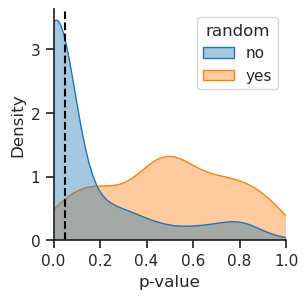

In [6]:
# Plot p-values, randomized vs real data
sns.set(style='ticks')
plt.figure(figsize=(3, 3))
plt.axvline(x=0.05, linestyle='dashed', color='black')
sns.kdeplot(data=lm_pval_df, x='pval', hue='random', common_norm=False, fill = True, alpha=0.4, palette=['#1f77b4', '#ff7f0e'])
## Set x-axis limits
plt.xlim(0, 1)
plt.xlabel('p-value')
plt.ylabel('Density')
sns.despine()
# Save plot as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/real_vs_random_pval.pdf", bbox_inches='tight')
plt.show();

Conclusion: Linear models work well, and only if the reporter activities are not randomly sampled.

---
**Choose best condition per TF**

In [7]:
# Integrate linear models to select the least noisy conditions per TF
cDNA_df_TF4 = cDNA_df_TF3[['tf', 'condition', 'pval_adj']].drop_duplicates()
## Write to file
cDNA_df_TF4.to_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/cDNA_df_TF4.tsv", sep='\t', index=False)

chosen_conditions = ref_conditions.merge(cDNA_df_TF4, how='left', on=['tf', 'condition'])
chosen_conditions.fillna(1, inplace=True)
chosen_conditions = chosen_conditions.groupby('tf').apply(lambda x: x.nsmallest(1, 'pval_adj', keep='all')).reset_index(drop=True)
chosen_conditions['cell'] = chosen_conditions['condition'].str.replace("_.*", "")
chosen_conditions = chosen_conditions.merge(tf_rna, how='left', on='tf')
chosen_conditions = chosen_conditions.groupby('tf').apply(lambda x: x.nlargest(1, 'nTPM')).reset_index(drop=True)
chosen_conditions = chosen_conditions[['tf', 'condition']].drop_duplicates()
chosen_conditions['tf_condition'] = chosen_conditions['tf'] + '_' + chosen_conditions['condition']
## Write to file
chosen_conditions.to_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/chosen_conditions.tsv", sep='\t', index=False)

---
### Explore linear model for a model TF - STAT3
Aim: Which design features matter for activity?

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

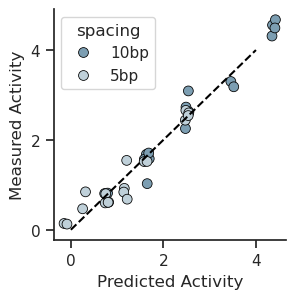

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


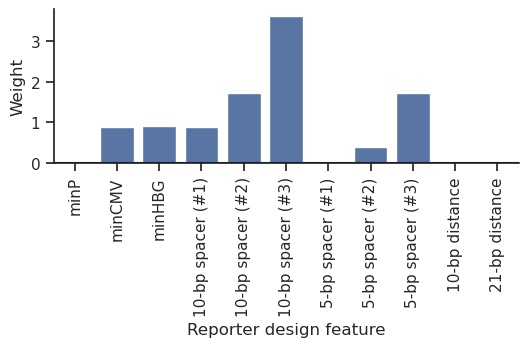

In [8]:
# Filter the data for STAT3 and mES_2i_LIF condition
filtered_data = cDNA_df_TF3[(cDNA_df_TF3['tf'] == 'STAT3') & (cDNA_df_TF3['condition'] == 'mES_2i_LIF')]

# Extract spacing and background from spacing_background column
filtered_data['spacing'] = filtered_data['spacing_background'].str.replace(":.*", "", regex=True)
filtered_data['background'] = filtered_data['spacing_background'].str.replace(".*:", "", regex=True)

filtered_data

# Create the scatter plot
sns.set(style='ticks')
plt.figure(figsize=(3, 3))
sns.scatterplot(data=filtered_data, x='activity_predicted', y='reporter_activity_minP', hue='spacing', palette={'10bp': '#7C9EB2', '5bp': '#BFD0D9'}, s=50, edgecolor='black')
## Add dashed line through origin
plt.plot([0, 4], [0, 4], linestyle='dashed', color='black')
plt.xlabel('Predicted Activity')
plt.ylabel('Measured Activity')
plt.xticks([0, 2, 4])
sns.despine()
plt.yticks([0, 2, 4])
## Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/STAT3_predicted_measured.pdf", bbox_inches='tight')
plt.show();


# Filter weight dataframe for tf == "STAT3_mES_2i_LIF"
weight_ex = weight[weight['tf'] == "STAT3_mES_2i_LIF"]

# Filter zero weights dataframe for rows with NA tf, set weight to 0 and pval to 1, and tf to "STAT3_mES_2i_LIF"
zero_weights = weight[pd.isna(weight['tf'])].copy()
zero_weights['weight'] = 0
zero_weights['pval'] = 1
zero_weights['tf'] = "STAT3_mES_2i_LIF"

# Concatenate weight_ex and zero_weights dataframes
weight_ex = pd.concat([weight_ex, zero_weights])

# Create feature_names dataframe
feature_names = pd.DataFrame({
    "features": ["minP", "mCMV", "hBGm", "10bp:1", "10bp:2", "10bp:3", "5bp:1", "5bp:2", "5bp:3", "10bp", "21bp"],
    "feature_names": ["minP", "minCMV", "minHBG", "10-bp spacer (#1)", "10-bp spacer (#2)", "10-bp spacer (#3)",
                      "5-bp spacer (#1)", "5-bp spacer (#2)", "5-bp spacer (#3)", "10-bp distance", "21-bp distance"]
})

# Merge weight_ex and feature_names dataframes
weight_ex = weight_ex.merge(feature_names, on="features", how="left")

# Create a bar plot
sns.set(style='ticks')
plt.figure(figsize=(6, 2))
sns.barplot(data=weight_ex, order = feature_names['feature_names'], x="feature_names", y="weight")
plt.axhline(y=0, color="black")
plt.xlabel("Reporter design feature")
plt.ylabel("Weight")
plt.xticks(rotation=90)
sns.despine()
## Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/STAT3_weights.pdf", bbox_inches='tight')
plt.show();

Conclusion: STAT3 activity depends mainly on spacer sequences.

---
### Weight heatmap for all TFs
Aim: Are there any general reporter design rules?

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: 

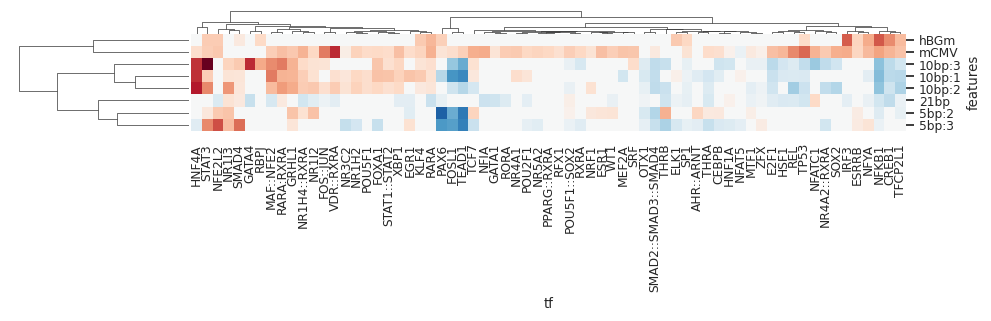

In [9]:
# Explore weights for all TFs
cDNA_df_TF5 = cDNA_df_TF4.copy()
cDNA_df_TF5['tf'] = cDNA_df_TF5['tf'] + '_' + cDNA_df_TF5['condition']
cDNA_df_TF5 = cDNA_df_TF5[['tf', 'pval_adj']].drop_duplicates()

# Add total variances as bar plot
exp_variance2 = exp_variance.copy()
exp_variance2 = exp_variance2[exp_variance2['tf'].isin(chosen_conditions['tf_condition'])]
exp_variance2 = exp_variance2[exp_variance2['feature'] == 'total']
exp_variance2 = exp_variance2[['tf', 'rel_sum_sq']].rename(columns={'rel_sum_sq': 'total_variance'})

weight2 = weight.copy()
weight2 = weight2[weight2['tf'].isin(chosen_conditions['tf_condition'])]
weight2 = weight2.merge(cDNA_df_TF5, how='left', on='tf')
weight2 = weight2.merge(exp_variance2, how='left', on='tf')
weight2 = weight2[(weight2['total_variance'] > 52) & (weight2['pval_adj'] < 0.05)]
weight2['tf'] = weight2['tf'].str.replace('_.*', '', regex=True)
weight2['weight'] = np.where(weight2['pval'] > 0.1, 0, weight2['weight'])
weight2 = weight2[['tf', 'features', 'weight']].drop_duplicates()
weight2 = weight2.pivot(index='tf', columns='features', values='weight')
weight2 = weight2[weight2.sum(axis=1, skipna=True) != 0]

myBreaks = np.concatenate((np.linspace(-2, 0, num=50+1), np.linspace(0.000001, 2, num=50)))

sns.set(font_scale=.8)
sns.clustermap(weight2.T,
               cmap='RdBu_r',
               method = 'ward',
               center=0,
               cbar_kws={'ticks': myBreaks},
               cbar_pos=None,
               linewidths=0,
               figsize=(10, 3.3),
               xticklabels=True,
               yticklabels=True)
## Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/weights_all_TFs.pdf", bbox_inches='tight')
plt.show();


Conclusion: Many TFs depend on the core promoter and spacer sequences. 

---
### Example: HNF4A reporters require a 10 bp spacer length

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

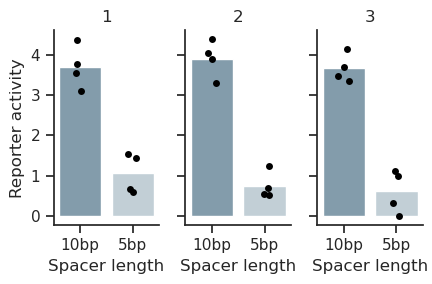

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

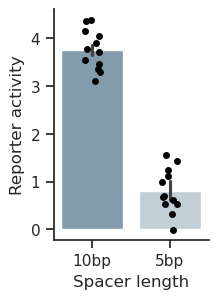

In [10]:
# Get distinct reporter features
reporter_features = cDNA_df[['promoter', 'spacing', 'distance', 'background', 'tf', 'reporter_id']].drop_duplicates()

# Filter HNF4A activities for HepG2_FBS condition
hnf1a_activities = cDNA_df_TF3[(cDNA_df_TF3['tf'] == 'HNF4A') & (cDNA_df_TF3['condition'] == 'HepG2_FBS')]
hnf1a_activities = hnf1a_activities.merge(reporter_features, how='left', on='reporter_id')
hnf1a_activities = hnf1a_activities[['reporter_id', 'spacing', 'background', 'reporter_activity_minP']].drop_duplicates()
hnf1a_activities['mean_spacer_activity'] = hnf1a_activities.groupby(['spacing', 'background'])['reporter_activity_minP'].transform('mean')
hnf1a_activities['background'] = hnf1a_activities['background'].astype('int')

sns.set(style='ticks')
g = sns.FacetGrid(hnf1a_activities, col='background', height=3, aspect=.5)
g.map(sns.barplot, 'spacing', 'mean_spacer_activity', palette={'10bp': '#7C9EB2', '5bp': '#BFD0D9'}, order=['10bp', '5bp'])
g.map(sns.stripplot, 'spacing', 'reporter_activity_minP', color="black", order=['10bp', '5bp'])
g.set_axis_labels('Spacer length', 'Reporter activity')
sns.despine()
g.set_titles("{col_name}")
## Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/HNF4A_spacer_activity.pdf", bbox_inches='tight')
plt.show();

sns.set(style='ticks')
plt.figure(figsize=(2, 3))
sns.barplot(data=hnf1a_activities, x='spacing', y='mean_spacer_activity', palette={'10bp': '#7C9EB2', '5bp': '#BFD0D9'}, order=['10bp', '5bp'], errorbar='sd')
sns.stripplot(data=hnf1a_activities, x='spacing', y='reporter_activity_minP', color="black", order=['10bp', '5bp'])
plt.xlabel('Spacer length')
plt.ylabel('Reporter activity')
sns.despine()

## Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/HNF4A_spacer_activity_comb.pdf", bbox_inches='tight')
plt.show();

---
### Which TFs have a spacer length preference?
Aim: Identify TFs that favor 5/10 bp spacer lengths.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

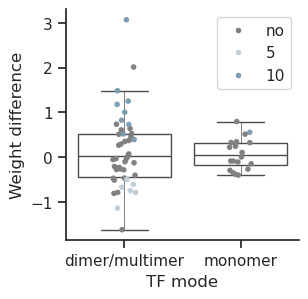

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

LeveneResult(statistic=6.3005156102106525, pvalue=0.01456914542465042)


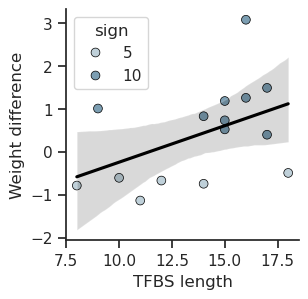

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

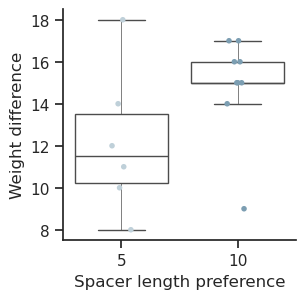

PearsonRResult(statistic=0.4596560374683067, pvalue=0.0847401447324714)


In [14]:
tf_properties = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/tf_binding_characterization.csv", sep=';')

weight_spacing = weight[weight['tf'].isin(chosen_conditions['tf_condition'])].copy()
weight_spacing = weight_spacing.merge(cDNA_df_TF5, how='left', on='tf')
weight_spacing['spacer_length'] = weight_spacing['features'].str.replace(":.*", "", regex=True)
weight_spacing = weight_spacing[weight_spacing['condition'] == "spacing_background"].copy()
weight_spacing['weight_spacer_min'] = weight_spacing.groupby(['tf', 'spacer_length'])['weight'].transform('min').abs()
weight_spacing['weight_spacer_max'] = weight_spacing.groupby(['tf', 'spacer_length'])['weight'].transform('max').abs()
weight_spacing['weight_spacer_length'] = weight_spacing.groupby(['tf', 'spacer_length'])['weight'].transform('mean')
weight_spacing = weight_spacing.drop(['features', 'pval', 'weight', 'pval_adj'], axis=1).drop_duplicates()



weight_spacing_length_sign = weight_spacing[weight_spacing['spacer_length'] == "5bp"].copy()
weight_spacing_length_sign = weight_spacing_length_sign[['tf', 'weight_spacer_max']].drop_duplicates()

weight_spacing_length_sign2 = weight_spacing[weight_spacing['spacer_length'] == "10bp"].copy()
weight_spacing_length_sign2 = weight_spacing_length_sign2[['tf', 'weight_spacer_min']].drop_duplicates()

weight_spacing_length = weight_spacing.drop(['weight_spacer_min', 'weight_spacer_max'], axis=1)
weight_spacing_length = weight_spacing_length.pivot(index=['tf', 'condition'], columns='spacer_length', values='weight_spacer_length')

weight_spacing_length = weight_spacing_length.merge(weight_spacing_length_sign, on='tf', how='left')

weight_spacing_length = weight_spacing_length.merge(weight_spacing_length_sign2, on='tf', how='left')

weight_spacing_length['tf'] = weight_spacing_length['tf'].str.replace('_.*', '', regex=True)
weight_spacing_length['spacer_effect'] = weight_spacing_length.apply(lambda x: 'Yes' if ((x['weight_spacer_min'] > 0.25 and x['weight_spacer_max'] < 1) or x['tf'] == 'STAT3') else 'No', axis=1)
weight_spacing_length['weight'] = weight_spacing_length['10bp'] - weight_spacing_length['5bp']
weight_spacing_length = weight_spacing_length[weight_spacing_length['tf'].isin(weight2.index)].copy()
weight_spacing_length = weight_spacing_length[['tf', 'weight', 'spacer_effect']].drop_duplicates()
weight_spacing_length = weight_spacing_length.merge(tf_properties, on='tf', how='left')

weight_spacing_length2 = weight_spacing_length.copy()
weight_spacing_length2['BS_spacer1'] = weight_spacing_length2['monomer_center_dist'] + 5
weight_spacing_length2['BS_spacer2'] = weight_spacing_length2['monomer_center_dist'] + 10
weight_spacing_length2['spacing_rotation1'] = weight_spacing_length2['BS_spacer1'] / 10.5
weight_spacing_length2['spacing_rotation2'] = weight_spacing_length2['BS_spacer2'] / 10.5
weight_spacing_length2['spacing_degree1'] = 2 * np.pi * weight_spacing_length2['spacing_rotation1']
weight_spacing_length2['spacing_degree2'] = 2 * np.pi * weight_spacing_length2['spacing_rotation2']
weight_spacing_length2['spacing_degree_transf1'] = np.cos(weight_spacing_length2['spacing_degree1'])
weight_spacing_length2['spacing_degree_transf2'] = np.cos(weight_spacing_length2['spacing_degree2'])
weight_spacing_length2['dif_spacing'] = -weight_spacing_length2['spacing_degree_transf1'] + weight_spacing_length2['spacing_degree_transf2']

weight_spacing_length2['mode2'] = np.where(weight_spacing_length2['mode'] == 'monomer', 'monomer', 'dimer/multimer')

weight_spacing_length2['sign'] = np.where(weight_spacing_length2['tf'].isin(['RARA:RXRA', 'HNF4A', 'STAT3', 'MAF::NFE2', 'FOXA1', 'KLF4', 'STAT1::STAT2', 'NR1H4::RXRA', 'RARA', 'XBP1']), '10', 'no')
weight_spacing_length2['sign'] = np.where(weight_spacing_length2['tf'].isin(['NFKB1', 'REL', 'TP53', 'TFCP2L1', 'CREB1', 'E2F1']), '5', weight_spacing_length2['sign'])
weight_spacing_length2['sign']

## Generate strip plot for each mode2
sns.set(style='ticks')
plt.figure(figsize=(3, 3))
sns.stripplot(data=weight_spacing_length2, x='mode2', y='weight', jitter=True, size=4, hue='sign', palette={'10': '#7C9EB2', '5': '#BFD0D9', 'no':'grey'})
sns.boxplot(data=weight_spacing_length2, x='mode2', y='weight', showcaps=True, 
            boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0.5})
plt.xlabel('TF mode')
plt.ylabel('Weight difference')
sns.despine()

# Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/TF_mode_weight.pdf", bbox_inches='tight')
plt.show();

## Perform levene's test for each mode2
from scipy.stats import levene

monomer_weights = weight_spacing_length2[weight_spacing_length2['mode2'] == 'monomer']['weight']
dimer_multimer_weights = weight_spacing_length2[weight_spacing_length2['mode2'] == 'dimer/multimer']['weight']

levene_stat = levene(monomer_weights, dimer_multimer_weights)
print(levene_stat)

## Plot BS length vs weight difference
sign_spacers = weight_spacing_length2[(weight_spacing_length2['sign'] != 'no') & (weight_spacing_length2['mode2'] == 'dimer/multimer')]

sns.set(style='ticks')
plt.figure(figsize=(3, 3))
sns.scatterplot(data=sign_spacers, x='BS_length', y='weight', hue='sign', palette={'10': '#7C9EB2', '5': '#BFD0D9'}, s=40, edgecolor='black')
# Add linear regression line
sns.regplot(data=sign_spacers, x='BS_length', y='weight', scatter=False, color='black')
plt.xlabel('TFBS length')
plt.ylabel('Weight difference')
sns.despine()
# Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/BS_length_weight.pdf", bbox_inches='tight')
plt.show();

sns.set(style='ticks')
plt.figure(figsize=(3, 3))
sns.stripplot(data=sign_spacers, x='sign', y='BS_length', jitter=True, size=4, hue='sign', palette={'10': '#7C9EB2', '5': '#BFD0D9'})
sns.boxplot(data=sign_spacers, x='sign', y='BS_length', showcaps=True, 
            boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0.5})
plt.xlabel('Spacer length preference')
plt.ylabel('Weight difference')
sns.despine()

# Save as pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/BS_length_weight_2.pdf", bbox_inches='tight')
plt.show();

# Compute correlation between BS length and weight difference
from scipy.stats import pearsonr

correlation = pearsonr(sign_spacers['BS_length'], sign_spacers['weight'])
print(correlation);

Conclusion: It seems that only dimeric/multimeric TFs have spacer length-preferences. bZIP TFs show a strong correlation between BS length and the impact of the spacer length - helical positioning important?

---
### Overview: Variance explained per design feature

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

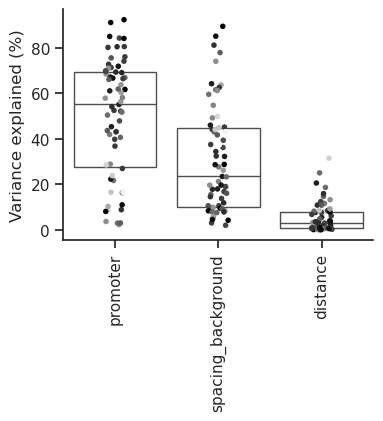

In [15]:
exp_variance_plot = exp_variance[exp_variance['tf'].isin(chosen_conditions['tf_condition'])]
exp_variance_plot['tf'] = exp_variance_plot['tf'].str.replace("_.*", "", regex=True)
exp_variance_plot['text'] = "TF = " + exp_variance_plot['tf']
exp_variance_plot = exp_variance_plot[exp_variance_plot['tf'].isin(weight2.index)]

total_variance = exp_variance_plot[exp_variance_plot['feature'] == "total"].copy()
total_variance = total_variance[['tf', 'rel_sum_sq']].rename(columns={'rel_sum_sq': 'total_variance'})

exp_variance_plot = exp_variance_plot[exp_variance_plot['feature'] != "total"].copy()
exp_variance_plot = exp_variance_plot.merge(total_variance, on='tf', how='left')
exp_variance_plot['mean_rel_sum_sq'] = exp_variance_plot.groupby('feature')['rel_sum_sq'].transform('median')

plt.figure(figsize=(4, 3))
## Add swarmplot
sns.stripplot(data=exp_variance_plot, x='feature', y='rel_sum_sq', hue='total_variance', palette='Greys', jitter=True, size=4, edgecolor='black')
## Add line to indicate median
sns.boxplot(data=exp_variance_plot, x='feature', y='rel_sum_sq', showcaps=False, color = "red",
            boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0})
plt.xlabel('')
plt.ylabel('Variance explained (%)')
plt.xticks(rotation=90)
plt.legend().remove()
## Save as pdf
sns.despine()
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure2/variance_explained.pdf", bbox_inches='tight')
plt.show();